In [399]:
import sys
import skimage
from skimage import data, feature, filters, color, img_as_float
from scipy import misc
from skimage.filters import threshold_yen
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from matplotlib import cm
from skimage.morphology import skeletonize
from skimage.feature import canny
import numpy as np
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage import io
from skimage import img_as_uint
import glob
from PIL import Image
import imageio
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
from skimage.color import label2rgb
import tifffile
import pims
import pandas as pd

from matplotlib.widgets  import RectangleSelector
import math
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.spatial.distance import euclidean
import operator
#import trackpy as tp


##### DON'T FORGET TO UPDATE PATH #####
#path = "/Users/alexandralong/Documents/UCSF/Dumont Lab/Analysis/Micromanipulation/MtrackJ_testing/20180412_Cell010"
path = "/Users/alexandralong/Documents/UCSF/Dumont Lab/Analysis/Micromanipulation/MtrackJ_testing/20180412_Cell007"
#path = "/Users/alexandralong/Documents/UCSF/Dumont Lab/Analysis/Micromanipulation/MtrackJ_testing/20180404_Cell007"
#path = "/Users/alexandralong/Documents/UCSF/Dumont Lab/Analysis/Micromanipulation/MtrackJ_testing/20180404_Cell005"

In [400]:
##### READ .CSV FILE SAVED IN PATH FOLDER: OUTPUT OF TRACKING USING FIJI'S MTRACKJ PLUGIN#####
##### ALSO, RENAME columns to have a universally common name, since sometimes fiji calls them by a few different variations #####
pole = pd.read_csv('%s/poles.csv'%path,encoding='latin-1') ###MUST SAVE MTRACKJ FILE AS CSV!!!!!!!!!
pole.rename(columns={pole.columns[3]:'x (um)'}, inplace=True)
pole.rename(columns={pole.columns[4]:'y (um)'}, inplace=True)
pole.rename(columns={pole.columns[5]:'t (sec)'},inplace=True)
kt = pd.read_csv('%s/kinetochores.csv'%path, encoding='latin-1') 
kt.rename(columns={kt.columns[3]:'x (um)'}, inplace=True)
kt.rename(columns={kt.columns[4]:'y (um)'}, inplace=True)
kt.rename(columns={kt.columns[5]:'t (sec)'},inplace=True)
needle = pd.read_csv('%s/needle.csv'%path, encoding='latin-1') 
needle.rename(columns={needle.columns[3]:'x (um)'}, inplace=True)
needle.rename(columns={needle.columns[4]:'y (um)'}, inplace=True)
needle.rename(columns={needle.columns[5]:'t (sec)'},inplace=True)

##### CALL X AND Y COORDINATES OF EACH POLE AS A VARIABLE #####
pole1_x = pole[(pole['TID'] == 1)]['x (um)']
pole1_x = pole1_x.reset_index(drop=True) ##### resets index to start from 0
pole1_y = pole[(pole['TID'] == 1)]['y (um)']
pole1_y = pole1_y.reset_index(drop=True)
pole2_x = pole[(pole['TID'] == 2)]['x (um)']
pole2_x = pole2_x.reset_index(drop=True)
pole2_y = pole[(pole['TID'] == 2)]['y (um)']
pole2_y = pole2_y.reset_index(drop=True)
pole_t = pole[(pole['TID'] == 1)]['t (sec)'] # assume both poles tracked for same time

##### CALL X AND Y AND TIME COORDINATES OF NEEDLE AS A VARIABLE #####
needle_x = needle[(needle['TID'] == 1)]['x (um)']
needle_y = needle[(needle['TID'] == 1)]['y (um)']
needle_t = needle[(needle['TID'] == 1)]['t (sec)']

##### CALL X AND Y COORDINATES OF KINETOCHORES AS A VARIABLE #####

kt_t = kt[(kt['TID'] == 1)]['t (sec)'] # assume all KT tracked for same time
kt3_t = kt[(kt['TID'] == 3)]['t (sec)']

## Do pair closer to needle first
kt1_x = kt[(kt['TID'] == 1)]['x (um)']
kt1_x = kt1_x.reset_index(drop=True) ##### resets index to start from 0
kt1_y = kt[(kt['TID'] == 1)]['y (um)']
kt1_y = kt1_y.reset_index(drop=True)

kt2_x = kt[(kt['TID'] == 2)]['x (um)']
kt2_x = kt2_x.reset_index(drop=True)
kt2_y = kt[(kt['TID'] == 2)]['y (um)']
kt2_y = kt2_y.reset_index(drop=True)


## Now do farthest pair from needle that is in focus
kt3_x = kt[(kt['TID'] == 3)]['x (um)']
kt3_x = kt3_x.reset_index(drop=True) ##### resets index to start from 0
kt3_y = kt[(kt['TID'] == 3)]['y (um)']
kt3_y = kt3_y.reset_index(drop=True)

kt4_x = kt[(kt['TID'] == 4)]['x (um)']
kt4_x = kt4_x.reset_index(drop=True)
kt4_y = kt[(kt['TID'] == 4)]['y (um)']
kt4_y = kt4_y.reset_index(drop=True)


In [434]:
# Quick plot of instantaneous velocity vs time
#plt.plot(needle_t,needle['v [microns/sec]'],marker='.',color='k')
#plt.plot(kt_t,kt[(kt['TID'] == 1)]['v [microns/sec]'],marker='.')
#plt.plot(kt_t,kt[(kt['TID'] == 2)]['v [microns/sec]'],marker='.')

#plt.plot(kt_t[0:-1],kt[(kt['TID'] == 3)]['v [microns/sec]'],marker='.')
#plt.plot(kt3_t,kt[(kt['TID'] == 3)]['v [microns/sec]'],marker='.')
#plt.plot(kt3_t,kt[(kt['TID'] == 4)]['v [microns/sec]'],marker='.')
#plt.xlabel('Time (sec)')
#plt.ylabel('Instant. velocity (um/sec)')



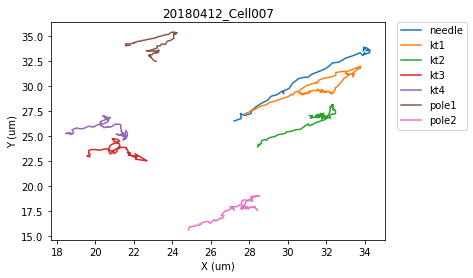

In [443]:
# map all the positions in XY image space
plt.plot(needle_x,needle_y,label='needle')
plt.plot(kt1_x,kt1_y,label='kt1')
plt.plot(kt2_x,kt2_y,label='kt2')
plt.plot(kt3_x,kt3_y,label='kt3')
plt.plot(kt4_x,kt4_y,label='kt4')
plt.plot(pole1_x,pole1_y,label='pole1')
plt.plot(pole2_x,pole2_y,label='pole2')
plt.xlabel('X (um)')
plt.ylabel('Y (um)')
plt.title(path[-16:])
#plt.legend()

plt.legend(bbox_to_anchor=(1.1, 0.9),
           bbox_transform=plt.gcf().transFigure)

plt.savefig('%s/PlotXY.tif'%(path),dpi=300)

In [403]:
## Now do some calculations

# first calculate the distance between the manipulated kt pair
kt1_kt2 = np.zeros(len(kt1_x)-1)
for i in range(len(kt1_x)-1):
    kt1_kt2[i] = euclidean((kt1_x[i],kt1_y[i]),(kt2_x[i],kt2_y[i]))

# then calculate the distance between the farthest kt pair
kt3_kt4 = np.zeros(len(kt3_x)-1)
for j in range(len(kt3_x)-1):
    kt3_kt4[j] = euclidean((kt3_x[j],kt3_y[j]),(kt4_x[j],kt4_y[j]))

# calculate the normalized needle position 
needle_pos = np.zeros(len(needle_x))
for q in range(len(needle_x)):
    needle_pos[q] = euclidean((needle_x[q],needle_y[q]),(needle_x[0],needle_y[0]))
    
# calculate the normalized kinetochore and pole positions relative to initial position
kt1_pos = np.zeros(len(kt1_x))
for k in range(len(kt1_x)):
    kt1_pos[k] = euclidean((kt1_x[k],kt1_y[k]),(kt1_x[0],kt1_y[0]))
    
kt2_pos = np.zeros(len(kt2_x))
for l in range(len(kt2_x)):
    kt2_pos[l] = euclidean((kt2_x[l],kt2_y[l]),(kt2_x[0],kt2_y[0]))
    
kt3_pos = np.zeros(len(kt3_x))
for m in range(len(kt3_x)):
    kt3_pos[m] = euclidean((kt3_x[m],kt3_y[m]),(kt3_x[0],kt3_y[0]))

kt4_pos = np.zeros(len(kt4_x))
for n in range(len(kt4_x)):
    kt4_pos[n] = euclidean((kt4_x[n],kt4_y[n]),(kt4_x[0],kt4_y[0]))
    
pole1_pos = np.zeros(len(pole1_x))
for o in range(len(pole1_x)):
    pole1_pos[o] = euclidean((pole1_x[o],pole1_y[o]),(pole1_x[0],pole1_y[0]))

pole2_pos = np.zeros(len(pole2_x))
for o in range(len(pole2_x)):
    pole2_pos[o] = euclidean((pole2_x[o],pole2_y[o]),(pole2_x[0],pole2_y[0]))
    

In [345]:
needle_to_pole1_dist

9.464966243996857

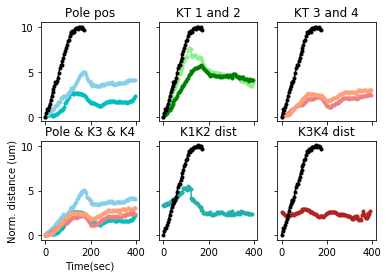

In [404]:
fig ,axes = plt.subplots(2, 3, sharex='all', sharey='all')

axes[1,0].set_xlabel('Time(sec)')
axes[1,0].set_ylabel('Norm. distance (um)')

axes[0,0].plot(pole_t,pole1_pos,color='c',marker='.')
axes[0,0].plot(pole_t,pole2_pos,color='skyblue',marker='.')
axes[0,0].plot(needle_t,needle_pos,color='k',marker='.')
axes[0,0].set_title('Pole pos')
axes[0,1].plot(kt_t,kt1_pos,color='lightgreen',marker='.')
axes[0,1].plot(kt_t,kt2_pos,color='green',marker='.')
axes[0,1].plot(needle_t,needle_pos,color='k',marker='.')
axes[0,1].set_title('KT 1 and 2')
axes[0,2].plot(kt3_t,kt3_pos,color = 'lightcoral',marker='.')
axes[0,2].plot(kt3_t,kt4_pos,color = 'lightsalmon',marker='.')
axes[0,2].plot(needle_t,needle_pos,color='k',marker='.')
axes[0,2].set_title('KT 3 and 4')

axes[1,1].plot(kt_t[0:-1],kt1_kt2,color='lightseagreen',marker='.')
axes[1,1].plot(needle_t,needle_pos,color='k',marker='.')
axes[1,1].set_title('K1K2 dist')
axes[1,2].plot(kt3_t[0:-1],kt3_kt4,color = 'firebrick',marker='.')
axes[1,2].plot(needle_t,needle_pos,color='k',marker='.')
axes[1,2].set_title('K3K4 dist')

## Looking at drift/translation
axes[1,0].plot(pole_t,pole1_pos,color='c',marker='.')
axes[1,0].plot(pole_t,pole2_pos,color='skyblue',marker='.')
#axes[1,0].scatter(needle_t,needle_pos)
axes[1,0].plot(kt3_t,kt3_pos,color = 'lightcoral',marker='.')
axes[1,0].plot(kt3_t,kt4_pos,color = 'lightsalmon',marker='.')
axes[1,0].set_title('Pole & K3 & K4')

plt.savefig('%s/Plot1.tif'%(path),dpi=300)


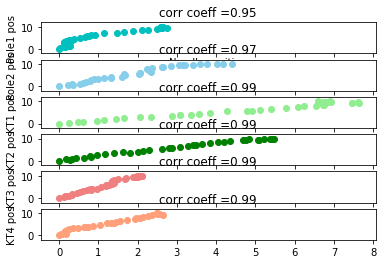

In [481]:
fig2 ,axes2 = plt.subplots(6, 1,sharex='all',sharey='all')
fig2 = plt.figure(figsize=(20,5))
index = np.argmax(needle_pos)
stop = needle_t[index]
start = needle_t[0]

axes2[0].set_xlabel('Needle position')
#axes2[0].set(adjustable='box-forced', aspect='equal')

ind1 = pole_t[pole_t == start]
ind2 = pole_t[pole_t == stop]

a = np.corrcoef(pole1_pos[ind1.index[0]:ind2.index[0]],needle_pos[0:index])
axes2[0].scatter(pole1_pos[ind1.index[0]:ind2.index[0]],needle_pos[0:index],color='c')
axes2[0].set_ylabel('Pole1 pos')
axes2[0].set_title('corr coeff =%s'%round(a[0,1],2))

a1 = np.corrcoef(pole2_pos[ind1.index[0]:ind2.index[0]],needle_pos[0:index])
axes2[1].scatter(pole2_pos[ind1.index[0]:ind2.index[0]],needle_pos[0:index],color='skyblue')
axes2[1].set_ylabel('Pole2 pos')
axes2[1].set_title('corr coeff =%s'%round(a1[0,1],2))

ind3 = kt_t[kt_t == start]
ind4 = kt_t[kt_t == stop]

a2 = np.corrcoef(kt1_pos[ind3.index[0]:ind4.index[0]],needle_pos[0:index])
axes2[2].scatter(kt1_pos[ind3.index[0]:ind4.index[0]],needle_pos[0:index],color='lightgreen')
axes2[2].set_ylabel('KT1 pos')
axes2[2].set_title('corr coeff =%s'%round(a2[0,1],2))

a3 = np.corrcoef(kt2_pos[ind3.index[0]:ind4.index[0]],needle_pos[0:index])
axes2[3].scatter(kt2_pos[ind3.index[0]:ind4.index[0]],needle_pos[0:index],color='green')
axes2[3].set_ylabel('KT2 pos')
axes2[3].set_title('corr coeff =%s'%round(a3[0,1],2))

a4 = np.corrcoef(kt3_pos[ind3.index[0]:ind4.index[0]],needle_pos[0:index])
axes2[4].scatter(kt3_pos[ind3.index[0]:ind4.index[0]],needle_pos[0:index],color='lightcoral')
axes2[4].set_ylabel('KT3 pos')
axes2[4].set_title('corr coeff =%s'%round(a4[0,1],2))

a5 = np.corrcoef(kt4_pos[ind3.index[0]:ind4.index[0]],needle_pos[0:index])
axes2[5].scatter(kt4_pos[ind3.index[0]:ind4.index[0]],needle_pos[0:index],color='lightsalmon')
axes2[5].set_ylabel('KT4 pos')
axes2[5].set_title('corr coeff =%s'%round(a5[0,1],2))

fig2.tight_layout()


#plt.show()
fig2.savefig('%s/corrcoeff.png'%(path),dpi=300)



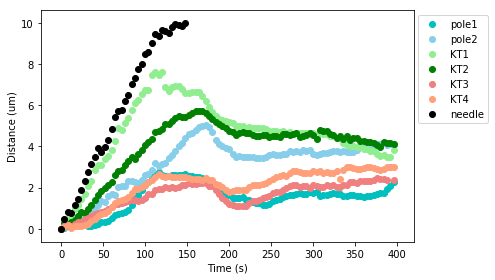

In [465]:
plt.scatter(pole_t,pole1_pos,label = 'pole1',color='c')
plt.scatter(pole_t,pole2_pos,label = 'pole2',color='skyblue')
plt.scatter(kt_t,kt1_pos,label = 'KT1',color='lightgreen')
plt.scatter(kt_t,kt2_pos,label = 'KT2',color='g')
plt.scatter(kt3_t,kt3_pos,label = 'KT3',color='lightcoral')
plt.scatter(kt3_t,kt4_pos,label = 'KT4',color='lightsalmon')
plt.xlabel('Time (s)')
plt.ylabel('Distance (um)')

plt.scatter(needle_t[0:index],needle_pos[0:index],label = 'needle',color='k')

#plt.legend()
plt.legend(bbox_to_anchor=(1.15, 0.95),
           bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('%s/NormDistPlot_overlayall.png'%(path),dpi=300)

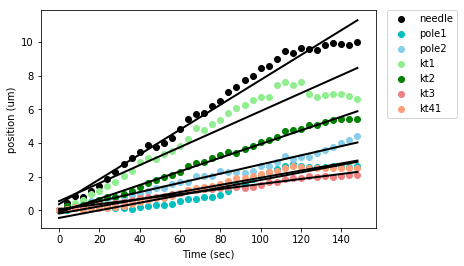

In [452]:
# get needle velocity
fit=np.polyfit(needle_t[0:index],needle_pos[0:index],1)
val = np.polyval(fit, needle_t[0:index])
plt.plot(needle_t[0:index],val, color='k', lw=2)
plt.scatter(needle_t[0:index],needle_pos[0:index],color='k',label='needle')
plt.xlabel('Time (sec)')
plt.ylabel('position (um)')



# get other velocities
fit_pole1 = np.polyfit(pole_t[ind1.index[0]:ind2.index[0]],pole1_pos[ind1.index[0]:ind2.index[0]],1)
val_pole1 = np.polyval(fit_pole1,pole_t[ind1.index[0]:ind2.index[0]])
plt.plot(pole_t[ind1.index[0]:ind2.index[0]],val_pole1,color = 'k',lw=2)
plt.scatter(pole_t[ind1.index[0]:ind2.index[0]],pole1_pos[ind1.index[0]:ind2.index[0]],color='c',label = 'pole1')

fit_pole2 = np.polyfit(pole_t[ind1.index[0]:ind2.index[0]],pole2_pos[ind1.index[0]:ind2.index[0]],1)
val_pole2 = np.polyval(fit_pole2,pole_t[ind1.index[0]:ind2.index[0]])
plt.plot(pole_t[ind1.index[0]:ind2.index[0]],val_pole2,color = 'k',lw=2)
plt.scatter(pole_t[ind1.index[0]:ind2.index[0]],pole2_pos[ind1.index[0]:ind2.index[0]],color='skyblue',label = 'pole2')

fit_kt1 = np.polyfit(kt_t[ind3.index[0]:ind4.index[0]],kt1_pos[ind3.index[0]:ind4.index[0]],1)
val_kt1 = np.polyval(fit_kt1,kt_t[ind3.index[0]:ind4.index[0]])
plt.plot(kt_t[ind3.index[0]:ind4.index[0]],val_kt1,color = 'k',lw=2)
plt.scatter(kt_t[ind3.index[0]:ind4.index[0]],kt1_pos[ind3.index[0]:ind4.index[0]],color='lightgreen',label = 'kt1')

fit_kt2 = np.polyfit(kt_t[ind3.index[0]:ind4.index[0]],kt2_pos[ind3.index[0]:ind4.index[0]],1)
val_kt2 = np.polyval(fit_kt2,kt_t[ind3.index[0]:ind4.index[0]])
plt.plot(kt_t[ind3.index[0]:ind4.index[0]],val_kt2,color = 'k',lw=2)
plt.scatter(kt_t[ind3.index[0]:ind4.index[0]],kt2_pos[ind3.index[0]:ind4.index[0]],color='g',label = 'kt2')

fit_kt3 = np.polyfit(kt3_t[ind3.index[0]:ind4.index[0]],kt3_pos[ind3.index[0]:ind4.index[0]],1)
val_kt3 = np.polyval(fit_kt3,kt3_t[ind3.index[0]:ind4.index[0]])
plt.plot(kt_t[ind3.index[0]:ind4.index[0]],val_kt3,color = 'k',lw=2)
plt.scatter(kt_t[ind3.index[0]:ind4.index[0]],kt3_pos[ind3.index[0]:ind4.index[0]],color='lightcoral',label = 'kt3')

fit_kt4 = np.polyfit(kt3_t[ind3.index[0]:ind4.index[0]],kt4_pos[ind3.index[0]:ind4.index[0]],1)
val_kt4 = np.polyval(fit_kt4,kt3_t[ind3.index[0]:ind4.index[0]])
plt.plot(kt_t[ind3.index[0]:ind4.index[0]],val_kt4,color = 'k',lw=2)
plt.scatter(kt_t[ind3.index[0]:ind4.index[0]],kt4_pos[ind3.index[0]:ind4.index[0]],color='lightsalmon',label = 'kt41')
plt.legend(bbox_to_anchor=(1.1, 0.9),
           bbox_transform=plt.gcf().transFigure)



# sanity checks commented below
#(needle_pos[8] - needle_pos[0]) / (needle_t[8] - needle_t[0])*60
#fit[0]*60


In [412]:
# now calculate some angles that may be important for drift correction etc

# needle distance from things at start (first frame needle is in focus)
kt12_center_x = (kt1_x[ind3.index[0]] + kt2_x[ind3.index[0]])/2
kt12_center_y = (kt1_y[ind3.index[0]] + kt2_y[ind3.index[0]])/2
kt34_center_x = (kt3_x[ind3.index[0]] + kt4_x[ind3.index[0]])/2
kt34_center_y = (kt3_y[ind3.index[0]] + kt4_y[ind3.index[0]])/2

needle_to_kt12_dist = euclidean((kt12_center_x,kt12_center_y),(needle_x[0],needle_y[0]))
needle_to_pole1_dist = euclidean((pole1_x[ind1.index[0]],pole1_y[ind1.index[0]]),(needle_x[0],needle_y[0]))

# spindle width (when needle first in focus)
kt12_to_kt34_dist = euclidean((kt12_center_x,kt12_center_y),(kt34_center_x,kt34_center_y)) 

# spindle length (when needle first in focus)
pole_to_pole_dist = euclidean((pole1_x[ind3.index[0]],pole1_y[ind3.index[0]]),(pole2_x[ind3.index[0]],pole2_y[ind3.index[0]]))

#aspect ratio
aspect_ratio = kt12_to_kt34_dist / pole_to_pole_dist

# pole1 to needle
v0 = np.array([pole1_x[ind3.index[0]],pole1_y[ind3.index[0]]]) - np.array([needle_x[0],needle_y[0]])
# pole1 to pole2
v1 = np.array([pole1_x[ind3.index[0]],pole1_y[ind3.index[0]]]) - np.array([pole2_x[ind3.index[0]],pole2_y[ind3.index[0]]])

needle_angle_PP = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
needle_angle_PP_deg = np.degrees(needle_angle_PP)
needle_dist_PP = needle_to_pole1_dist * np.math.sin(needle_angle_PP)

# needle to mean KT12 pos
v2 = np.array([kt12_center_x,kt12_center_y]) - np.array([needle_x[0],needle_y[0]])

# mean KT12 pos to mean KT34 pos
v3 = np.array([kt12_center_x,kt12_center_y]) - np.array([kt34_center_x,kt34_center_y])

needle_angle_meta = np.math.atan2(np.linalg.det([v2,v3]),np.dot(v2,v3))
needle_dist_meta = needle_to_kt12_dist * np.math.sin(needle_angle_meta)

# angle of needle movement relative to pole-pole axis

# pole-pole axis slope over time
pp_slope = np.zeros(len(pole_t))
#change in slope (every other datapoint to see more clearly where hotspots are)
delta_pp_slope = np.zeros(len(pp_slope)-2)
for t in range(len(pole_t)):
    pp_slope[t] = (pole1_y[t]-pole2_y[t]) / (pole1_x[t]-pole2_x[t])
for q in range(len(pp_slope)-2):
    delta_pp_slope[q] = abs(pp_slope[q+2] - pp_slope[q])


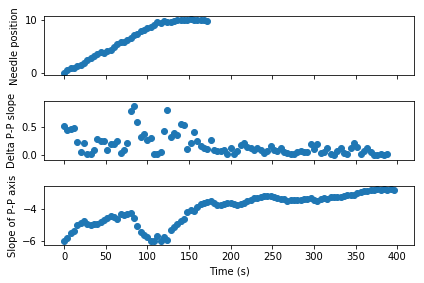

In [457]:
fig3 ,axes3 = plt.subplots(3, 1,sharex='all')
axes3[2].set_xlabel('Time (s)')
axes3[0].scatter(needle_t,needle_pos)
axes3[0].set_ylabel('Needle position')
axes3[1].scatter(pole_t[0:-2],delta_pp_slope)
axes3[1].set_ylabel('Delta P-P slope')
axes3[2].scatter(pole_t,pp_slope)
axes3[2].set_ylabel('Slope of P-P axis')
fig3.tight_layout()

In [435]:
#df = pd.DataFrame(columns=['frame','object','length (um)',])
#df_coords = pd.DataFrame(columns=['frame','object','x (px)','y (px)','particle'])

# make everything into np arrays since they're much easier to work with
output = dict([
    ('Name',path),
    ('PoleTime',np.array(pole_t)),
    ('KT1Time',np.array(kt_t)),
    ('KT3Time',np.array(kt3_t)),
    ('NeedleTime',np.array(needle_t)),
    ('NeedleX',np.array(needle_x)),
    ('NeedleY',np.array(needle_y)),    
    ('Pole1X',np.array(pole1_x)),
    ('Pole1Y',np.array(pole1_y)),
    ('Pole2X',np.array(pole2_x)),
    ('Pole2Y',np.array(pole2_y)),
    ('KT1X',np.array(kt1_x)),
    ('KT1Y',np.array(kt1_y)),
    ('KT2X',np.array(kt2_x)),
    ('KT2Y',np.array(kt2_y)),
    ('KT3X',np.array(kt3_x)),
    ('KT3Y',np.array(kt3_y)),
    ('KT4X',np.array(kt4_x)),
    ('KT4Y',np.array(kt4_y)),
    ('Pole1Pos',np.array(pole1_pos)),
    ('Pole2Pos',np.array(pole2_pos)),  
    ('KT1Pos',np.array(kt1_pos)),
    ('KT2Pos',np.array(kt2_pos)),
    ('KT3Pos',np.array(kt3_pos)),
    ('KT4Pos',np.array(kt4_pos)),
    ('NeedlePos',np.array(needle_pos)),
    ('KK12',np.array(kt1_kt2)),
    ('KK34',np.array(kt3_kt4)),
     ])




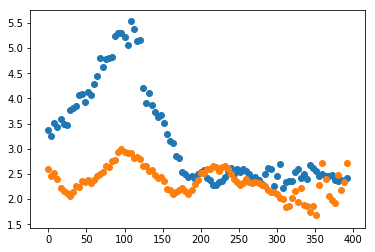

In [440]:
plt.scatter(output['PoleTime'][0:-1],output['KK12'])
plt.scatter(output['PoleTime'][0:-1],output['KK34'])